In [15]:
import pandas as pd
import pickle as pkl
import numpy as np

import matplotlib.pyplot as plt

import scanpy as sc
%matplotlib inline
import matplotlib

import scanpy as sc
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import glob

### Random baseline

In [16]:
def generate_random_rounds(all_genes, round0=None, rounds = 16, sample_size=64):
    past_set =list(all_genes)
    random_rounds = {}
    if round0 is not None:
        random_rounds[0] = round0
    else:
        random_rounds[0] = np.random.choice(all_genes, sample_size)
    
    for i in range(1,rounds):
        selection_set = set(past_set).difference(set(random_rounds[i-1]))
        random_rounds[i] = np.concatenate([random_rounds[i-1], np.random.choice(list(selection_set), sample_size)])
        past_set = list(selection_set)
        
    return random_rounds

def generate_random_rounds_custom(all_genes, rounds = 16, sample_sizes=None):
    past_set =list(all_genes)
    random_rounds = {}
    random_rounds[0] = []
    
    for i in range(1,rounds):
        selection_set = set(past_set).difference(set(random_rounds[i-1]))
        random_rounds[i] = np.concatenate([random_rounds[i-1], np.random.choice(list(selection_set), sample_sizes[i])])
        past_set = list(selection_set)
        
    return random_rounds

def get_all_sampled_genes(exp_path):
    all_sampled_genes = []
    num_rounds = len(glob.glob(exp_path + '*'))
    for i in range(num_rounds):
        exp_path_ = exp_path + str(i) + '.npy'
        all_sampled_genes.append(np.load(exp_path_))
    return all_sampled_genes

def get_successful_sample_sizes(sampled_genes):
    sizes = []
    prev_size = 0
    for sample in sampled_genes:
        sizes.append(len(sample)-prev_size)
        prev_size = prev_size + sizes[-1]
    return sizes

def return_hits(arr, remove_essential=True):
    res = list(set(arr).intersection(set(topmovers)))
    if remove_essential == True:
        res = list(set(res).difference(set(essential_genes)))
    return res

In [17]:
## Get essential genes

essential_genes = '/dfs/user/yhr/bagel/CEGv2.txt'
essential_genes = pd.read_csv(essential_genes, delimiter='\t')['GENE'].tolist()

In [98]:
REPS = np.arange(1, 10).astype('str')
ACQUISITION_FUNCTIONS = ["random", "softuncertain", "topuncertain",
                         "marginsample", "coreset", "badge",
                         "kmeans_embedding", "kmeans_data", "discobax"]

essential_flag = True
dataset = 'carnevale_adenosine'

if dataset =='scharenberg':
    sample_size= 32
else:
    sample_size= 128

num_steps = 5
ai_steps = 5

data_formal_name = {'scharenberg': 'Scharenberg22',
                 'ifng': 'Schmidt22 (IFNG)',
                 'il2': 'Schmidt22 (IL2)',
                 'steinhart': 'Steinhart',
                 'sanchez': 'Sanchez21_down',
                 'carnevale_adenosine': 'Carnevale22'}

data_name_map = {'scharenberg': 'Scharenberg22',
                 'ifng': 'IFNG',
                 'il2': 'IL2',
                 'steinhart': 'Steinhart_crispra_GD2_D22',
                 'scharenberg': 'Scharenberg22',
                 'sanchez': 'Sanchez21_down',
                 'carnevale_adenosine': 'Carnevale22_Adenosine'}

ai_run_name = {'scharenberg': '32_Scharenberg',
                 'ifng': 'IFNG',
                 'il2': 'IL2',
                 'steinhart': 'Steinhart',
                 'sanchez': 'Sanchez21_down',
                 'carnevale_adenosine': '128_Carnevale22_Adenosine'}

result_name_map = {'scharenberg': 'scharenberg_2022',
                 'ifng': 'Schmidt_2021_ifng',
                 'il2': 'Schmidt_2021_il2',
                 'steinhart': 'steinhart_2024_crispra_GD2_D22',
                 'scharenberg': 'scharenberg_2022',
                 'sanchez': 'sanchez_2021_down',
                 'carnevale_adenosine': 'Carnevale_2022_Adenosine'}
    
num_reps = len(REPS)
batch_size=sample_size

data_df = pd.read_csv('/dfs/user/yhr/AI_RA/research_assistant/datasets/ground_truth_'+data_name_map[dataset]+'.csv')
topmovers = np.load('/dfs/user/yhr/AI_RA/research_assistant/datasets/topmovers_'+data_name_map[dataset]+'.npy')

if essential_flag:
    topmovers = list(set(topmovers).difference(set(essential_genes)))

if dataset == 'sanchez':
    ai_data_path = '/dfs/user/qhwang/bio_combo/v1_all_Sanchez21_down'
else:
    ai_data_path = glob.glob(f'/dfs/scratch0/jianv/bio-logs/agent-final/v4_all3_again50*{ai_run_name[dataset]}*')[0]

try:
    data_df = data_df.rename(columns={'0':'Gene', '1':'Score'})
except:
    pass

all_genes = data_df['Gene'].values
data_df = data_df.set_index('Gene')

### ML model results

In [103]:
data_name = result_name_map[dataset]

def decapital(string):
    return string[0].lower() + string[1:]

def read_ml_rounds(data_name, num_steps, batch_size, ML_model_name):
    #path = f'/dfs/user/yhr/genedisco/genedisco/results/Schmidt_2021_'+data_name+'/'
    
    ## special path for steinhart
    path = f'/dfs/user/yhr/genedisco/genedisco/results/'+data_name+'/'
    if ML_model_name == 'discobax':
        path = f'/dfs/user/yhr/DiscoBAX/discobax/apps/results/'+data_name+'/'
    print(path)
    all_pred_genes = []
    for i in range(num_steps):
        try:
            if ML_model_name == 'discobax':
                all_pred_genes.append(pd.read_pickle(path+'cycle_{}/selected_indices.pkl'.format(i)))
            else:
                all_pred_genes.append(pd.read_pickle(path+'cycle_{}/selected_indices.pickle'.format(i)))
        except:
            print('No sampling round {}'.format(i))
    return all_pred_genes

def get_ml_hits(data_name, ML_model_name, num_steps = num_steps, 
                batch_size=batch_size,
                num_reps=2):
    
    ml_rounds = {}
    ml_hits = {}
    ml_hit_rates = {}
    
    for rep in range(1, num_reps+1):
        rep=str(rep)
        if ML_model_name == 'discobax':
            ml_rounds[rep] = read_ml_rounds(decapital(data_name) + '_' + ML_model_name + '_{}'.format(rep)+f'/{decapital(data_name)}_achilles_0.1_bayesian_mlp_discobax_20_1000', 
                                        num_steps, batch_size=batch_size, ML_model_name=ML_model_name)
        else:
            ml_rounds[rep] = read_ml_rounds(data_name + '_' + ML_model_name + '_{}'.format(rep), 
                                        num_steps, batch_size=batch_size, ML_model_name=ML_model_name)
        ml_hits[rep] = []
        ml_hit_rates[rep] = []
        for step in range(num_steps):
            ml_hits[rep].append(return_hits(ml_rounds[rep][step]))
            ml_hit_rates[rep].append(len(ml_hits[rep][-1])/len(topmovers))
        
    return ml_hit_rates, ml_hits


def get_random_hits(sample_size, num_steps = num_steps, num_reps=3):
    random_rounds = {}
    random_hits = {}
    random_hit_rates = {}

    for rep in range(1, num_reps+1):
        rep=str(rep)
        random_rounds[rep] = generate_random_rounds(all_genes, rounds = num_steps, sample_size=sample_size)
        #random_rounds[rep] = generate_random_rounds_custom(all_genes, rounds = num_steps, 
        #                                                   sample_sizes=sample_sizes[rep])

        random_hits[rep] = []
        random_hit_rates[rep] = []
        for step in range(num_steps):
            random_hits[rep].append(return_hits(random_rounds[rep][step]))
            random_hit_rates[rep].append(len(random_hits[rep][-1])/len(topmovers))
            
    return random_hit_rates, random_hits

def get_avg_hit_score(hits):
    return data_df.loc[hits].abs().mean().values[0]

def get_avg_hit_scores(hits, num_reps=3):
    hit_scores = []
    
    for rep in range(1, num_reps+1):
        hit_score_rep = []
        for hit_list in hits[str(rep)]:
            hit_score_rep.append(get_avg_hit_score(hit_list))
        hit_scores.append(hit_score_rep)

    return np.round(np.nanmean(np.array(hit_scores), 0),3)


def get_ai_hits(data_path, num_steps = 10, batch_size=batch_size,
                num_reps=10):
    
    ml_rounds = {}
    ml_hits = {}
    ml_hit_rates = {}
    
    for rep in range(1, num_reps+1):
        rep=str(rep)
        predicted_genes = glob.glob(data_path + f'/dummy_summary{rep}/sampled_genes_*')
        predicted_genes = np.sort(predicted_genes)

        ml_hits[rep] = []
        ml_hit_rates[rep] = []
        for file in predicted_genes:
            pred_genes = np.load(file)
            ml_hits[rep].append(return_hits(pred_genes))
            ml_hit_rates[rep].append(len(ml_hits[rep][-1])/len(topmovers))
        
    return ml_hit_rates, ml_hits

In [104]:
# calculate the mean and standard deviation of the random data
random_hit_rates, random_hits = get_random_hits(sample_size, num_steps = num_steps, num_reps=num_reps)
random_mean = np.mean(np.array([x for x in random_hit_rates.values()]),0)
random_std = np.std(np.array([x for x in random_hit_rates.values()]),0)

# calculate the mean and standard deviation for the model predictions
ml_mean = {}
ml_std = {}
ml_scores = {}

ai_mean = {}
ai_std = {}
ai_scores = {}

for ML_model_name in ACQUISITION_FUNCTIONS:
    
    print(ML_model_name)
    
    try:
        ml_hit_rates, ml_hits = get_ml_hits(data_name, ML_model_name, num_steps = num_steps, 
                                            num_reps=num_reps,
                                            batch_size=batch_size)
        ml_scores[ML_model_name] = get_avg_hit_scores(ml_hits, num_reps=num_reps)

        ml_mean[ML_model_name] = np.round(np.mean(np.array([x for x in ml_hit_rates.values()]),0),3)
        ml_std[ML_model_name] = np.round(np.std(np.array([x for x in ml_hit_rates.values()]),0),3)
    except:
        print('Failed')
        

ai_hit_rates, ai_hits = get_ai_hits(ai_data_path, num_steps = ai_steps, batch_size=batch_size,
                                            num_reps=num_reps)
#ai_scores['agent_final'] = get_avg_hit_scores(ai_hits, num_reps=num_reps)

ai_mean['agent_final'] = np.round(np.mean(np.array([x for x in ai_hit_rates.values() if len(x)!= 0]),0),3)
ai_std['agent_final'] = np.round(np.std(np.array([x for x in ai_hit_rates.values() if len(x)!= 0]),0),3)

random
/dfs/user/yhr/genedisco/genedisco/results/Carnevale_2022_Adenosine_random_1/
/dfs/user/yhr/genedisco/genedisco/results/Carnevale_2022_Adenosine_random_2/
/dfs/user/yhr/genedisco/genedisco/results/Carnevale_2022_Adenosine_random_3/
/dfs/user/yhr/genedisco/genedisco/results/Carnevale_2022_Adenosine_random_4/
/dfs/user/yhr/genedisco/genedisco/results/Carnevale_2022_Adenosine_random_5/
/dfs/user/yhr/genedisco/genedisco/results/Carnevale_2022_Adenosine_random_6/
/dfs/user/yhr/genedisco/genedisco/results/Carnevale_2022_Adenosine_random_7/
/dfs/user/yhr/genedisco/genedisco/results/Carnevale_2022_Adenosine_random_8/
/dfs/user/yhr/genedisco/genedisco/results/Carnevale_2022_Adenosine_random_9/
softuncertain
/dfs/user/yhr/genedisco/genedisco/results/Carnevale_2022_Adenosine_softuncertain_1/
/dfs/user/yhr/genedisco/genedisco/results/Carnevale_2022_Adenosine_softuncertain_2/
/dfs/user/yhr/genedisco/genedisco/results/Carnevale_2022_Adenosine_softuncertain_3/
/dfs/user/yhr/genedisco/genedisco/

In [105]:
ml_mean

{'random': array([0.008, 0.016, 0.025, 0.032, 0.039]),
 'softuncertain': array([0.007, 0.015, 0.021, 0.026, 0.035]),
 'topuncertain': array([0.008, 0.014, 0.02 , 0.027, 0.033]),
 'marginsample': array([0.008, 0.014, 0.019, 0.026, 0.032]),
 'coreset': array([0.008, 0.013, 0.022, 0.03 , 0.038]),
 'badge': array([0.007, 0.013, 0.02 , 0.028, 0.036]),
 'kmeans_embedding': array([0.006, 0.011, 0.017, 0.022, 0.029]),
 'kmeans_data': array([0.007, 0.011, 0.016, 0.023, 0.03 ]),
 'discobax': array([0.008, 0.012, 0.02 , 0.03 , 0.038])}

In [106]:
ai_mean

{'agent_final': array([0.009, 0.017, 0.024, 0.034, 0.042])}

### Plot Results

In [107]:
import matplotlib
font = {
        'size'   : 16}

matplotlib.rc('font', **font)

In [108]:
colors = [
    "#1f77b4",  # Muted blue
    "#ff7f0e",  # Safety orange
    "#2ca02c",  # Cooked asparagus green
    "#d62728",  # Brick red
    "#9467bd",  # Muted purple
    "#8c564b",  # Chestnut brown
    "#e377c2",  # Raspberry yogurt pink
    "#7f7f7f",  # Middle gray
    "#17becf"   # Blue-teal for the main model to stand out
]

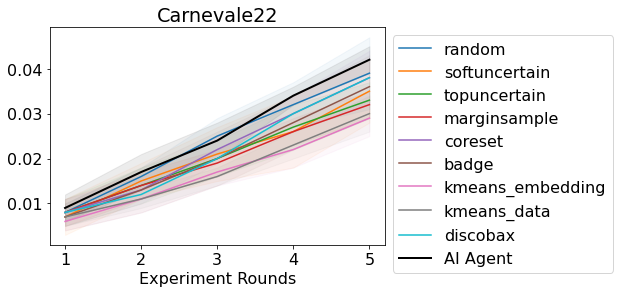

In [109]:
for i, (model, data) in enumerate(ml_mean.items()):
    _ = plt.plot(np.arange(num_steps)+1, ml_mean[model], label=model, color=colors[i])
    plt.fill_between(np.arange(num_steps)+1, 
                     ml_mean[model] - ml_std[model], 
                     ml_mean[model] + ml_std[model],
                     color=colors[i], alpha=0.05)

plt.plot(np.arange(num_steps) + 1, ai_mean['agent_final'], label='AI Agent', color='black', linewidth=2)
plt.fill_between(np.arange(num_steps)+1, 
                     ai_mean['agent_final'] - ai_std['agent_final'], 
                     ai_mean['agent_final'] + ai_std['agent_final'],
                     color='gray', alpha=0.15)

plt.title(data_formal_name[dataset])
plt.xlabel('Experiment Rounds')
#plt.ylabel('Top-K Recall')
plt.legend(bbox_to_anchor=(1,1))
plt.savefig(dataset+'.svg', bbox_inches = 'tight')
